In [54]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import RegressorMixin, TransformerMixin
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet, ElasticNetCV


In [55]:
# Import custom classes
from supervised_model_pipeline import EdaToolbox, RegressorMultiModelEvaluator

## Inspect the data

In [56]:
# Load the training data
train_full_df = pd.read_csv('../data/train.csv').drop('Id', axis=1)
train_full_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Create an EdaToolbox object

In [57]:
# Initialize the EdaToolbox
target_col = 'SalePrice'
eda = EdaToolbox(train_full_df, target_column=target_col)

## First check the distribution of the target column and select an appropriate target column transformer

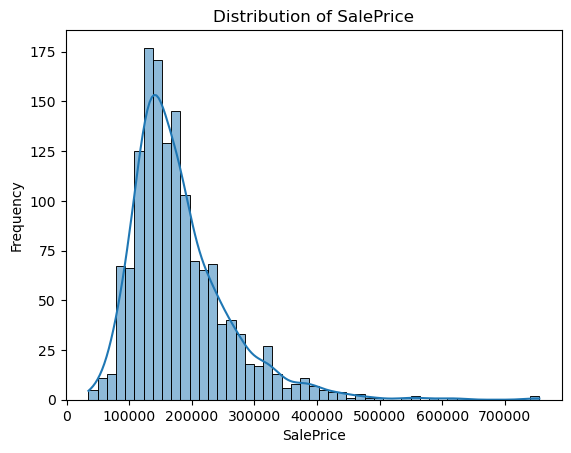

In [58]:
# Plot target column distribution
eda.plot_regression_target_column_distribution()

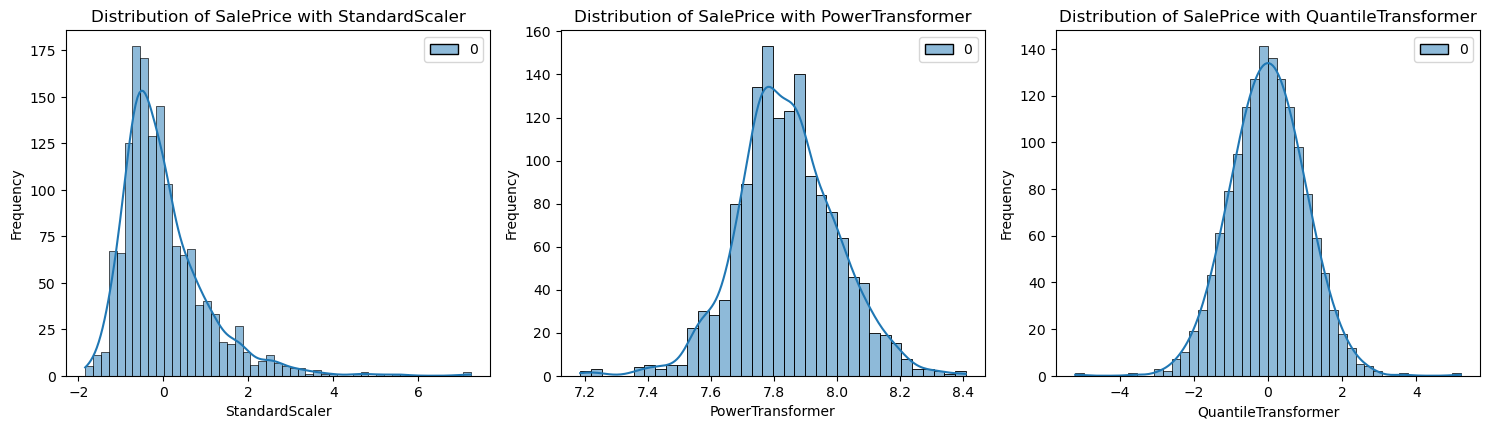

In [59]:
# It is not normally distributed. It has a long tail to the right. Need to try different target transformations
target_transformation_dict: dict[str, TransformerMixin] = {
    'StandardScaler': StandardScaler(),
    'PowerTransformer': PowerTransformer(standardize=False),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal', n_quantiles=500, random_state=42),
}
eda.plot_regression_target_column_distribution_variations(target_transformation_dict)

# NOTE: The PowerTransformer evenly distributes the data but not around Zero which is good for this dataset
#       because there are no negative SalePrice values.

In [60]:
# Create a dict of models for preliminary testing of target transformations
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=1.0, random_state=42),
    'ElasticNet Regression': ElasticNet(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV()
}


In [61]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features
model_pred_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict)
model_pred_df

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV
StandardScaler,0.425360,0.425237,1.103302,0.922071,0.438173,0.437097,0.423935
PowerTransformer,0.055131,0.055102,0.171965,0.171965,0.054301,0.054316,0.054885
QuantileTransformer,0.336151,0.335978,1.102105,0.881407,0.332025,0.333955,0.334855


## Set the target and feature column tranformers

In [62]:
# Looks like the CV Models perform the best with a PowerTransformer.
# NOTE: These are pretty good RMSE scores with very basic encoding and no feature selection
eda.target_transformer = PowerTransformer(standardize=False)
eda.feature_transformer = eda.get_basic_ordinal_feature_transformer()

## Prepare the data for feature selection

In [63]:
# Gather initial column information sorted by data type and max value count to check for columns with high cardinality that can be pruned
col_info_df = eda.gather_initial_column_info()
col_info_df.head()

,data_type,max_value_count_pct,most_frequent_value,unique_values,missing_values,missing_values_pct,top_10_values
Utilities,object,0.999315,AllPub,2,0,0.0,"Index(['AllPub', 'NoSeWa'], dtype='object', na..."
Street,object,0.995890,Pave,2,0,0.0,"Index(['Pave', 'Grvl'], dtype='object', name='..."
Condition2,object,0.989726,Norm,8,0,0.0,"Index(['Norm', 'Feedr', 'Artery', 'RRNn', 'Pos..."
RoofMatl,object,0.982192,CompShg,8,0,0.0,"Index(['CompShg', 'Tar&Grv', 'WdShngl', 'WdSha..."
Heating,object,0.978082,GasA,6,0,0.0,"Index(['GasA', 'GasW', 'Grav', 'Wall', 'OthW',..."


In [64]:
# Set pruning thresholds on the eda object according to column data type and cardinality for this dataset
eda.prune_infreq_categorical = 0.9
eda.prune_infreq_numerical = 0.95
eda.prune_pct_missing = 0.8

## Feature analysis

In [65]:
# Frist do basic scaling and encoding to see what the correlation and coefficient numbers look like
fa_df = eda.get_regression_feature_analysis_df(
    eda.get_basic_ordinal_feature_transformer(), 
    eda.target_transformer
)
fa_df.head()

Best RidgeCV alpha: 100.0 (R^2 score:  0.90)


c:\Users\jim\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
numerical__GrLivArea,0.697017,0.018441,0.105747,inf,0.159296,0.320902,1.195657
numerical__OverallQual,0.815044,0.026660,0.191351,4.225290,0.219882,0.038297,1.099882
ordinal_neighborhood__Neighborhood,0.740302,0.023124,0.169299,3.429729,0.208808,0.023143,0.995377
numerical__YearBuilt,0.588037,0.004407,0.967901,8.363907,0.210607,0.188031,0.991081
numerical__TotRmsAbvGrd,0.532020,0.009357,0.524814,5.298685,0.115297,0.311225,0.967899


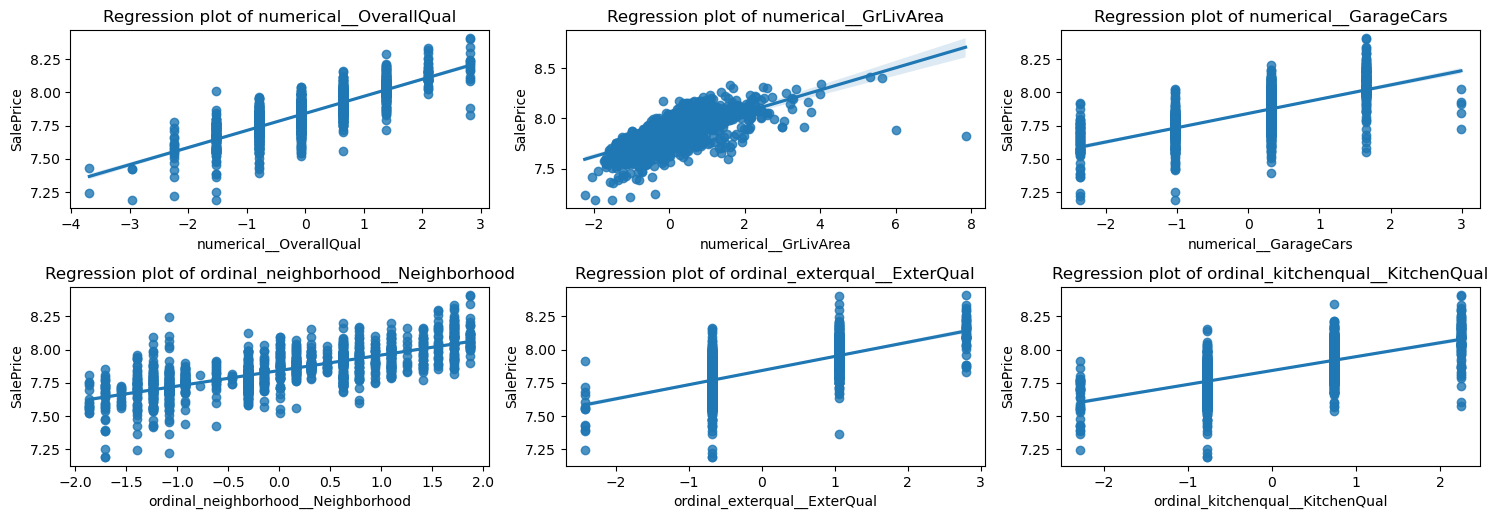

In [66]:
# Plot out the highly correlated features
eda.plot_regression_feature_correlations(
    eda.get_basic_ordinal_feature_transformer(), 
    eda.target_transformer, 
    corr_min=0.65
)

## Perform unsupervised feature selection

In [67]:
# Try using SFS (SequentialFeatureSelector) to select the top 15features
selected_features = eda.perform_unsupervised_regression_sfs_feature_selection(
    eda.feature_transformer,
    eda.target_transformer,
    n_features=20
)
selected_features

RidgeCV best alpha 1000.0
Selected 20 features by forward sequential featureselection in 16.818 seconds


['MSSubClass',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'GarageCars',
 'ScreenPorch',
 'MSZoning',
 'Neighborhood',
 'Condition1',
 'BsmtQual',
 'BsmtExposure',
 'HeatingQC',
 'CentralAir',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'SaleCondition']

In [68]:
# Update EDA object with selected features
eda.selected_feature_list = selected_features

# Now get the list of important ordinal columns
final_ordinal_cols = eda.get_final_ordinal_col_names(selected_features)
len(final_ordinal_cols), final_ordinal_cols

(11,
 ['MSZoning',
  'Neighborhood',
  'Condition1',
  'BsmtQual',
  'BsmtExposure',
  'HeatingQC',
  'CentralAir',
  'KitchenQual',
  'Functional',
  'FireplaceQu',
  'SaleCondition'])

## Perform final EDA with selected features and ordinal columns

In [69]:
# Reset transformer properties to use the selected columns and ordinal columns
eda.ordinal_encoding_col_dict = {}
for col_name in final_ordinal_cols:
    eda.add_ordinal_encoding_column(col_name, None)

eda.feature_transformer = eda.create_feature_transformer()
eda.feature_transformer

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(memory='named_steps',
                                          steps=[('pruner',
                                                  SimplePruner(infreq=0.95,
                                                               pct_miss=0.8)),
                                                 ('selector',
                                                  SelectedFeaturesTransformer(selected_feature_list=['MSSubClass',
                                                                                                     'OverallQual',
                                                                                                     'OverallCond',
                                                                                                     'YearBuilt',
                                                                                                     'GrLivArea',
                                                                                                     'BsmtFullBath',
                                                                                                     'FullBath',
                                                                                                     'GarageCars',
                                                                                                     'ScreenPorch',
                                                                                                     'MSZoning',
                                                                                                     'Neighborhood',
                                                                                                     'Condition1...
                                                                 unknown_value=-1)),
                                                 ('scaler', StandardScaler())]),
                                 ['FireplaceQu']),
                                ('ordinal_salecondition',
                                 Pipeline(memory='named_steps',
                                          steps=[('SaleCondition',
                                                  OrdinalEncoder(categories=[['AdjLand',
                                                                              'Abnorml',
                                                                              'Family',
                                                                              'Alloca',
                                                                              'Normal',
                                                                              'Partial']],
                                                                 encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('scaler', StandardScaler())]),
                                 ['SaleCondition'])])

In [70]:
# Check feature analysis to ensure we have no multicollinearity (ie. no infinite vifs)
feature_analysis_df = eda.get_regression_feature_analysis_df(
    feature_transformer=eda.feature_transformer, 
    target_transformer=eda.target_transformer)
feature_analysis_df.head()

Best RidgeCV alpha: 100.0 (R^2 score:  0.89)


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
numerical__GrLivArea,0.697017,0.044935,0.000143,2.572717,0.245430,0.479055,1.466438
numerical__OverallQual,0.815044,0.030220,0.079704,3.573147,0.348639,0.143798,1.337702
numerical__FullBath,0.594022,0.008370,0.983664,2.309484,0.271329,0.354775,1.228496
ordinal_neighborhood__Neighborhood,0.740302,0.024208,0.084697,3.041381,0.339147,0.075871,1.179529
numerical__YearBuilt,0.588037,0.008216,0.817121,3.925898,0.322290,0.245291,1.163834


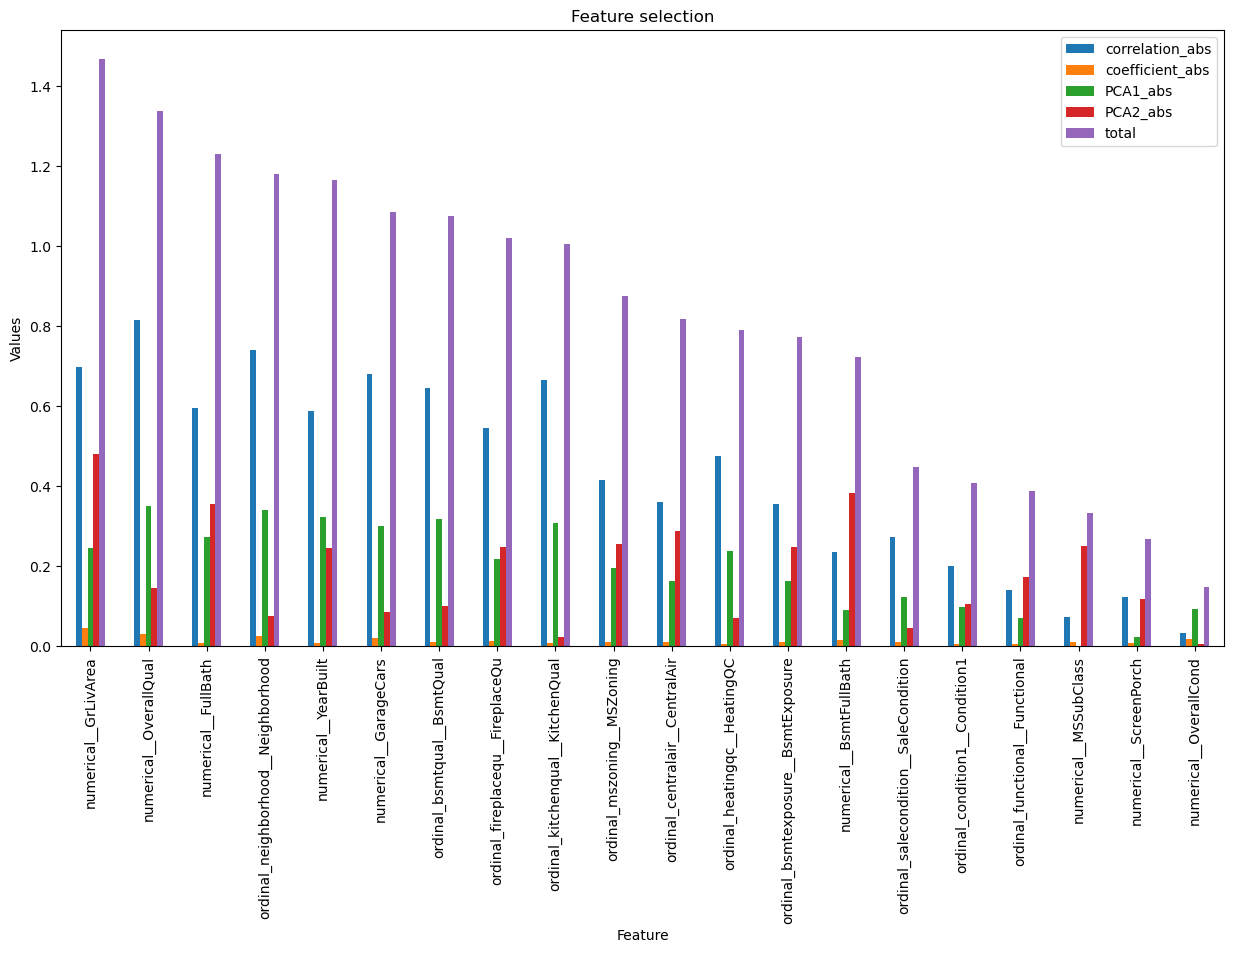

In [71]:
eda.plot_important_features(feature_analysis_df)

# Now do model analysis for multiple regression models

In [72]:
# Reload the data just to be safe
train_full_df = pd.read_csv('../data/train.csv')

# Create an instance of RegressorMultiModelEvaluator and set various properties
reg = RegressorMultiModelEvaluator(train_full_df, target_column='SalePrice')
reg.set_column_transformer_properties(selected_feature_list=selected_features, ordinal_feature_list=final_ordinal_cols)
reg.set_target_column_transformer(eda.target_transformer)

In [73]:
# Create a dict of models to test
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV(alphas=np.logspace(-6, 6, num=7))
}

In [74]:
# Evaluate the models
eval_df = reg.evaluate_models(model_dict)
eval_df

Number original X cols: 80
Number scaled X cols: 20


,train_r2,mse,r2,r2_adj,lr_cv_mean,lr_cv_std,time
model_name,,,,,,,
Linear Regression,0.883077,0.002854,0.902888,0.895721,0.888845,0.04363,0.007539
Ridge Regression,0.883077,0.002855,0.902857,0.895688,0.888845,0.04363,0.014488
LassoCV,0.883072,0.002862,0.902618,0.895431,0.888845,0.04363,0.077542
ElasticNetCV,0.883071,0.002862,0.902593,0.895405,0.888845,0.04363,0.080584
RidgeCV,0.881848,0.002970,0.898928,0.891469,0.888845,0.04363,0.013778


In [75]:
# Get the best model
reg.best_model_name

'Linear Regression'

## Now use the best model to predict on the test data

In [76]:
# Load test data
test_full_df = pd.read_csv('../data/test.csv')
test_full_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [77]:
# Make predictions
predictions = reg.predict(test_full_df)
predictions

array([115569.77570917, 140338.86910763, 170151.30341842, ...,
       156427.35625108, 115010.49992356, 228090.28673589])

In [78]:
# Prepare submission file
new_submission_df = pd.DataFrame({
    'Id': test_full_df['Id'],
    'SalePrice': predictions
})
new_submission_df.to_csv('../data/new_submission_3.csv', index=False)
new_submission_df

,Id,SalePrice
0,1461,115569.775709
1,1462,140338.869108
2,1463,170151.303418
3,1464,190653.158328
4,1465,193033.961166
...,...,...
1454,2915,92760.053371
1455,2916,85377.644176
1456,2917,156427.356251
1457,2918,115010.499924
